In [60]:
import pandas as pd
import pyomo.environ as pyo
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random

In [20]:
m = pyo.ConcreteModel()

m.exset1 = pyo.RangeSet(1,3)
m.exset2 = pyo.RangeSet(2,6,2)
#m.expar2 = pyo.Param(m.exset1, initialize=m.exset2)
#pyo.value(m.expar2[1])
exdict = {pyo.value(i)+1: pyo.value(i) for i in m.exset2}
m.N = pyo.Param(initialize=5, mutable=True)
m.J = pyo.RangeSet(1,m.N*2+3)
m.N = 4
Jdict = {i: i for i in m.J}
Jdict
Jarr = [i for i in m.J]
Jarr

type(np.array([0.0])).name

AttributeError: type object 'numpy.ndarray' has no attribute 'name'

In [62]:
def build_model(sbounds=1, N=1):
    '''
    Builds farmland allocation model
    
    Inputs:
    sbounds: crop yield scenario bounds as fractions of average yield
    N: number of scenarios
    '''
    # Declare model
    m = pyo.ConcreteModel()
    
    if 'int' in str(type(sbounds)) or 'float' in str(type(sbounds)):
        sbounds = (sbounds,sbounds)
    
    if len(sbounds) == 1:
        sbounds = (sbounds[0],sbounds[0])
    # Verify that input arguments are valid
    assert sbounds[0] > 0, "Scenario bounds cannot be negative."
    if len(sbounds) > 2:
        N = len(sbounds)
        m.N = pyo.Param(initialize=N)
        m.J = pyo.RangeSet(1,m.N)
        m.Sfrac = pyo.Param(m.J,initialize={i+1:sbounds[i] for i in range(N)})
    else:
        assert N%1 == 0 and N > 0, "Number of scenarios N must be a positive integer."
        if sbounds[0] == sbounds[1]:
            assert N==1, "N must be 1 if scenario bounds are not specified."
        else:
            assert N > 1, "N must be greater than 1 if two different scenario bounds are specified."
            assert sbounds[0] < sbounds[1], "Second scenario bound must be greater than first scenario bound."
        m.N = pyo.Param(initialize=N)
        m.J = pyo.RangeSet(1,m.N)
        m.sbounds = pyo.Param([0,1], initialize={0:sbounds[0], 1:sbounds[1]})
        if N > 1:
            m.Sfracset = pyo.RangeSet(m.sbounds[0], m.sbounds[1]+(m.sbounds[1]-m.sbounds[0])/(m.N-1)*0.5, (m.sbounds[1]-m.sbounds[0])/(m.N-1))
        else:
            m.Sfracset = pyo.Set(initialize=[pyo.value(m.sbounds[0])])
        m.Sfrac = pyo.Param(m.J,initialize={i:pyo.value(m.Sfracset[i]) for i in m.J})
    
    m.xind = pyo.RangeSet(1,3)
    m.yind = pyo.RangeSet(1,2)
    m.wind = pyo.RangeSet(1,4)
    
    # Define additional parameters
    m.Px = pyo.Param(m.xind, initialize={1:150, 2:230, 3:260})
    m.Py = pyo.Param(m.yind, initialize={1:238, 2:210})
    m.Pw = pyo.Param(m.wind, initialize={1:170, 2:150, 3:36, 4:10})
    m.totalarea = pyo.Param(initialize=500)
    m.quota = pyo.Param(initialize=6000)
    m.baseyield = pyo.Param(m.xind,initialize={1:2.5, 2:3.0, 3:20.0})
    m.Feed = pyo.Param(m.yind, initialize={1:200,2:240})
    m.weight = pyo.Param(initialize=1.0/m.N)
    
    # Define variables
    m.x = pyo.Var(m.xind, within=pyo.NonNegativeReals)
    m.y = pyo.Var(m.yind, m.J, within=pyo.NonNegativeReals)
    m.w = pyo.Var(m.wind, m.J, within=pyo.NonNegativeReals)
    
    # Define objective
    @m.Objective()
    def costobj(m):
        return sum(m.Px[i]*m.x[i] for i in m.xind) + m.weight*sum(sum(m.Py[i]*m.y[i,j] for i in m.yind)-sum(m.Pw[i]*m.w[i,j] for i in m.wind) for j in m.J)
    
    # Define constraints
    # mass balance on wheat and corn
    @m.Constraint(m.yind, m.J)
    def feedconsumption(m, i, j):
        return m.Feed[i] == m.baseyield[i]*m.Sfrac[j]*m.x[i] + m.y[i,j] - m.w[i,j]
    
    # mass balance on beets
    @m.Constraint(m.J)
    def beetmb(m, j):
        return m.baseyield[3]*m.Sfrac[j]*m.x[3] == m.w[3,j] + m.w[4,j]
    
    # beet quota constraint
    @m.Constraint(m.J)
    def quotaconstraint(m, j):
        return m.w[3,j] <= m.quota
    
    # farmland availability
    @m.Constraint()
    def farmlandconstraint(m):
        return sum(m.x[i] for i in m.xind) <= m.totalarea
    
    return m
    
    
    

In [48]:
def get_results(m, detailed_WS=False):
    '''
    '''
    x_df = pd.DataFrame()
    cropdict = {1: "Wheat", 2:"Corn", 3:"Sugar Beets"}
    N = pyo.value(m.N)
    
    solver = pyo.SolverFactory('glpk')
    
    results1 = solver.solve(m)
    
    x_RP = pd.Series({cropdict[i]:pyo.value(m.x[i]) for i in m.xind})
    x_df["RP"] = x_RP
    profit_RP = -pyo.value(m.costobj)
    
    EV = np.mean(np.array([pyo.value(m.Sfrac[j]) for j in m.J]))
    m_EV = build_model(EV)
    results_EV = solver.solve(m_EV)
    x_EV = pd.Series({cropdict[i]:pyo.value(m_EV.x[i]) for i in m_EV.xind})
    x_df["EV"] = x_EV
    for i in m.xind:
        m.x[i].fix(pyo.value(m_EV.x[i]))
    results_EEV = solver.solve(m)
    profit_EEV = -pyo.value(m.costobj)
    VSS = profit_RP - profit_EEV
    
    plant_PI_df = pd.DataFrame()
    profit_PI = np.zeros(N)
    for j in m.J:
        sreal = pyo.value(m.Sfrac[j])
        m_PI = build_model(sreal)
        results_PI = solver.solve(m_PI)
        profit_PI[j-1] = -pyo.value(m_PI.costobj)
        if detailed_WS:
            x_WS = pd.Series({cropdict[i]:pyo.value(m_PI.x[i]) for i in m_PI.xind})
            x_df["{:+.0f}%".format((sreal-1)*100.0)] = x_WS
    WS_mean = np.mean(profit_PI)
    EVPI = WS_mean - profit_RP
    
    profits = pd.Series({"RP profit": profit_RP, "EEV profit": profit_EEV, "WS mean profit": WS_mean, "VSS": VSS, "EVPI": EVPI})
    if detailed_WS:
        for j in m.J:
            sreal = pyo.value(m.Sfrac[j])
            profits["{:+.0f}%".format((sreal-1)*100.0)] = profit_PI[j-1]
    
    
    
    return profits, x_df

In [49]:
model_N3 = build_model([0.8, 1.2], 3)
profits_N3, x_N3 = get_results(model_N3, True)


In [50]:
profits_N3

RP profit         108390.000000
EEV profit        107240.000000
WS mean profit    115405.555556
VSS                 1150.000000
EVPI                7015.555556
-20%               59950.000000
+0%               118600.000000
+20%              167666.666667
dtype: float64

In [51]:
x_N3

,RP,EV,-20%,+0%,+20%
Wheat,170.0,120.0,100.0,120.0,183.333333
Corn,80.0,80.0,25.0,80.0,66.666667
Sugar Beets,250.0,300.0,375.0,300.0,250.000000


In [55]:
model_N5 = build_model([0.5, 1.5], 5)
profits_N5, x_N5 = get_results(model_N5, True)

In [56]:
profits_N5

RP profit          99100.000000
EEV profit         92360.000000
WS mean profit    107904.333333
VSS                 6740.000000
EVPI                8804.333333
-50%              -40400.000000
-25%               43733.333333
+0%               118600.000000
+25%              179605.000000
+50%              237983.333333
dtype: float64

In [57]:
x_N5

,RP,EV,-50%,-25%,+0%,+25%,+50%
Wheat,180.0,120.0,160.0,106.666667,120.0,196.0,246.666667
Corn,80.0,80.0,0.0,0.000000,80.0,64.0,53.333333
Sugar Beets,240.0,300.0,340.0,393.333333,300.0,240.0,200.000000


In [68]:
def mci(df, c=0.95):
    outdict = {}
    for col in df:
        data = df[col]
        a = 1.0*np.asarray(data)
        n = len(a)
        m, se = np.mean(a), stats.sem(a)
        h = se*stats.t.ppf((1+c)/2.0, n-1)
        c_interval = pd.Series({"Average": m, "Lower confidence bound": m-h, "Upper confidence bound": m+h})
        outdict[col] = c_interval
    outdf = pd.DataFrame(outdict).T
    return outdf

In [69]:
N = 10
nsamples = 10
profitdict = {}
xdict = {}
for i in range(nsamples):
    slist = [random.uniform(0.5,1.5) for j in range(N)]
    model = build_model(slist)
    profits, x_df = get_results(model)
    profitdict[i] = profits
    xdict[i] = x_df['RP']

x_samples = pd.DataFrame(xdict).T
profit_samples = pd.DataFrame(profitdict).T
x_interval = mci(x_samples)
profit_interval = mci(profit_samples)
    


In [70]:
x_samples

,Wheat,Corn,Sugar Beets
0,108.538733,84.536797,306.924470
1,151.362662,78.227642,270.409696
2,172.072594,78.762193,249.165213
3,187.339139,74.349352,238.311510
4,196.379131,77.642782,225.978087
5,202.300326,80.621330,217.078344
6,150.190623,94.235120,255.574257
7,137.113820,78.613050,284.273131
8,158.316028,104.356810,237.327162
9,145.313469,105.307391,249.379141


In [71]:
profit_samples

,RP profit,EEV profit,WS mean profit,VSS,EVPI
0,79046.829987,74596.187585,84170.742019,4450.642402,5123.912032
1,122286.931700,121256.716229,129913.173804,1030.215472,7626.242104
2,102850.739568,98134.960408,109575.357653,4715.779160,6724.618085
3,103593.200986,94405.183951,109759.101569,9188.017035,6165.900583
4,115228.531034,110963.839553,122879.709349,4264.691481,7651.178315
5,107554.017142,105383.956773,118118.812774,2170.060369,10564.795632
6,87833.456965,77189.865665,92035.799942,10643.591300,4202.342977
7,51826.384066,41566.523074,57187.311407,10259.860992,5360.927341
8,68065.817988,60174.318422,76200.420649,7891.499565,8134.602662
9,61557.046197,57168.625391,70035.596290,4388.420806,8478.550093


In [72]:
x_interval

,Average,Lower confidence bound,Upper confidence bound
Wheat,160.892652,140.160513,181.624792
Corn,85.665247,77.472549,93.857944
Sugar Beets,253.442101,233.919013,272.965189


In [73]:
profit_interval

,Average,Lower confidence bound,Upper confidence bound
RP profit,89984.295563,72774.409451,107194.181675
EEV profit,84084.017705,65455.146417,102712.888993
WS mean profit,96987.602546,79377.680871,114597.524220
VSS,5900.277858,3487.586581,8312.969136
EVPI,7003.306982,5658.596423,8348.017542


In [100]:
def saa(N, nsamples=10):
    profitdict = {}
    xdict = {}
    for i in range(nsamples):
        slist = [random.uniform(0.5,1.5) for j in range(N)]
        model = build_model(slist)
        profits, x_df = get_results(model)
        profitdict[i] = profits
        xdict[i] = x_df['RP']

    x_samples = pd.DataFrame(xdict).T
    profit_samples = pd.DataFrame(profitdict).T
    x_interval = mci(x_samples)
    profit_interval = mci(profit_samples)
    return x_interval, profit_interval
    


In [101]:
x_interval, profit_interval = saa(100)

In [102]:
x_interval

,Average,Lower confidence bound,Upper confidence bound
Wheat,168.649329,163.638065,173.660592
Corn,86.600233,84.630967,88.569499
Sugar Beets,244.750438,239.913419,249.587457


In [103]:
profit_interval

,Average,Lower confidence bound,Upper confidence bound
RP profit,102210.290087,96367.306669,108053.273505
EEV profit,97320.616231,91126.937901,103514.294560
WS mean profit,110903.219171,105067.998416,116738.439927
VSS,4889.673857,4097.624522,5681.723191
EVPI,8692.929084,8350.431766,9035.426402


In [79]:
x_interval
profit_interval

,Average,Lower confidence bound,Upper confidence bound
RP profit,102835.028864,96460.508019,109209.549710
EEV profit,97990.921806,91151.178171,104830.665442
WS mean profit,111573.981502,105047.515931,118100.447072
VSS,4844.107058,4233.515994,5454.698122
EVPI,8738.952637,8448.570157,9029.335118


In [80]:
print(x_interval)

                Average  Lower confidence bound  Upper confidence bound
Wheat        171.547175              165.196165              177.898185
Corn          85.719649               83.141249               88.298049
Sugar Beets  242.733177              238.065469              247.400884


In [105]:
profit_dict = {}
value_dict = {}
x_wheat_dict = {}
x_corn_dict = {}
x_beets_dict = {}
p_RP_saa_dict = {}
for N in range(3,102,2):
    model = build_model([0.5, 1.5], N)
    p_series_N, x_df_N = get_results(model)
    x_interval, profit_interval = saa(N)
    p_RP_saa_dict[N] = profit_interval.loc['RP profit', 'Average']
    x_df_N['SAA'] = x_interval['Average']
    profit_dict[N] = p_series_N[:'WS mean profit']
    value_dict[N] = p_series_N['VSS':]
    x_wheat_dict[N] = x_df_N.loc['Wheat']
    x_corn_dict[N] = x_df_N.loc['Corn']
    x_beets_dict[N] = x_df_N.loc['Sugar Beets']

profit_df = pd.DataFrame(profit_dict).T
p_RP_saa = pd.Series(p_RP_saa_dict)
profit_df['SAA'] = p_RP_saa
value_df = pd.DataFrame(value_dict).T
x_wheat_df = pd.DataFrame(x_wheat_dict).T
x_corn_df = pd.DataFrame(x_corn_dict).T
x_beets_df = pd.DataFrame(x_beets_dict).T


<Figure size 432x288 with 0 Axes>

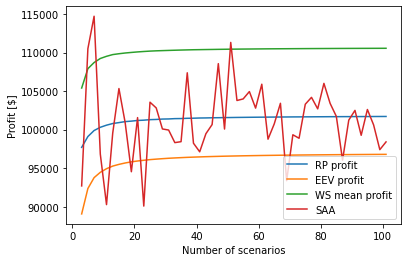

In [106]:
plt.figure(1)
profit_df.plot()
plt.xlabel('Number of scenarios')
plt.ylabel('Profit [$]')
plt.show()

<Figure size 432x288 with 0 Axes>

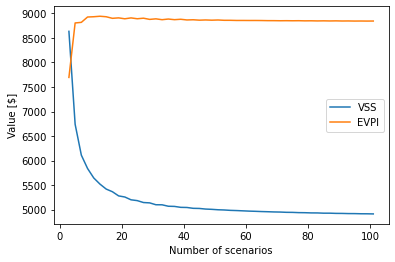

In [107]:
plt.figure(2)
value_df.plot()
plt.xlabel('Number of scenarios')
plt.ylabel('Value [$]')
plt.show()

<Figure size 432x288 with 0 Axes>

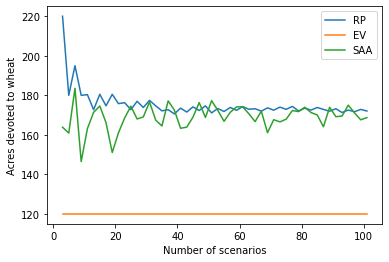

In [108]:
plt.figure(3)
x_wheat_df.plot()
plt.xlabel('Number of scenarios')
plt.ylabel('Acres devoted to wheat')
plt.show()

<Figure size 432x288 with 0 Axes>

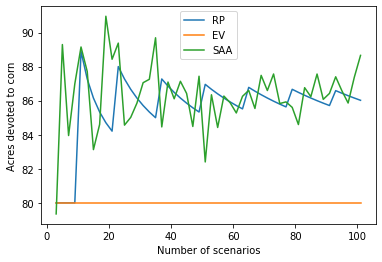

In [109]:
plt.figure(4)
x_corn_df.plot()
plt.xlabel('Number of scenarios')
plt.ylabel('Acres devoted to corn')
plt.show()

<Figure size 432x288 with 0 Axes>

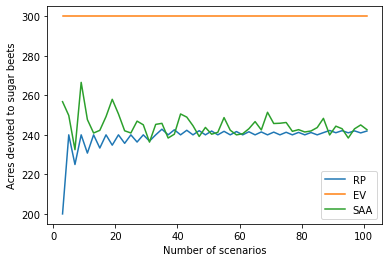

In [110]:
plt.figure(5)
x_beets_df.plot()
plt.xlabel('Number of scenarios')
plt.ylabel('Acres devoted to sugar beets')
plt.show()

In [93]:
x_corn_df.head()

,RP,EV
3,80.000000,80.0
5,80.000000,80.0
7,80.000000,80.0
9,80.000000,80.0
11,88.888889,80.0
